# Table of Contents
1. Importing Libraries and Data
2. Subsetting, Wrangling, and Cleaning Time Series Data
3. Time Series Analysis: Decomposition
4. Testing for Stationary
5. Stationarizing Time Series Data

## 1. Importing Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'insert_API_key'

In [3]:
#importing US Energy Info Administration Data "Airline Ticket Price Index, Monthly"
data = quandl.get('EIA/STEO_ACTKFUS_M')

In [4]:
data.head()

,Value
Date,
1990-01-31,136.6
1990-02-28,140.0
1990-03-31,143.8
1990-04-30,145.6
1990-05-31,146.3


In [5]:
data.shape

(408, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

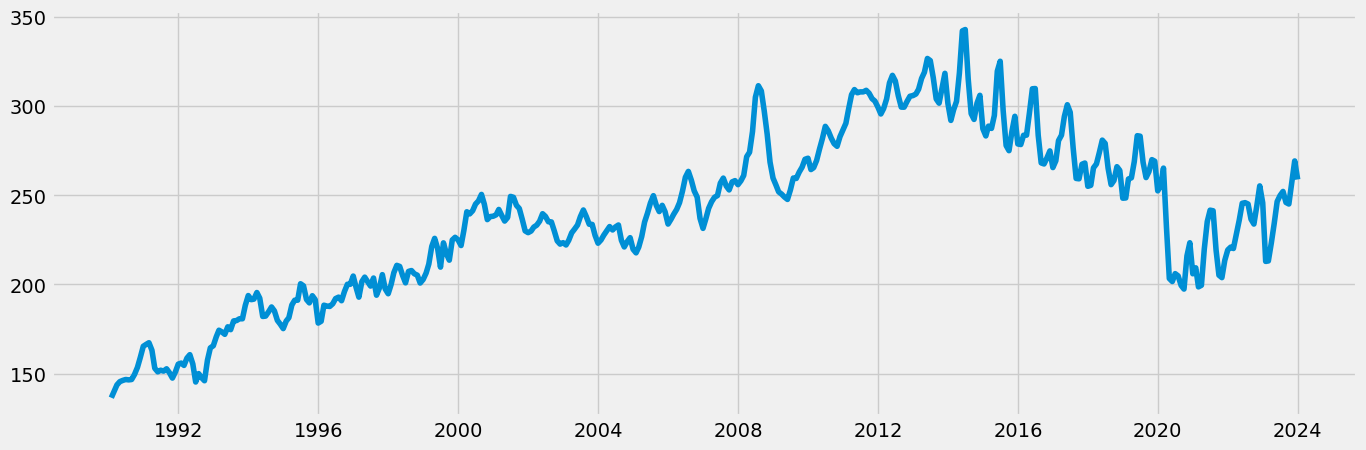

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

## 2. Subsetting, Wrangling, and Cleaning Time Series Data

In [9]:
# Reset index to use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1990-01-31,136.6
1,1990-02-28,140.0
2,1990-03-31,143.8
3,1990-04-30,145.6
4,1990-05-31,146.3


In [11]:
#create subset with dates I want to use

data_sub = data_2.loc[(data_2['Date'] >= '1992-01-01') & (data_2['Date'] < '2022-01-01')]

A subset was made to exclude forecasted data and only show data for the last 20 years.

In [12]:
# Set the "Date" column as the index

from datetime import datetime

# Create a datetime column from "Date.""
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
# Set the datetime as the index of the dataframe.
data_sub = data_sub.set_index('datetime') 
# Drop the "Date" column.
data_sub.drop(['Date'], axis=1, inplace=True) 
# Checking output
data_sub.head()

,Value
datetime,
1992-01-31,156.0
1992-02-29,154.7
1992-03-31,158.8
1992-04-30,160.7
1992-05-31,155.5


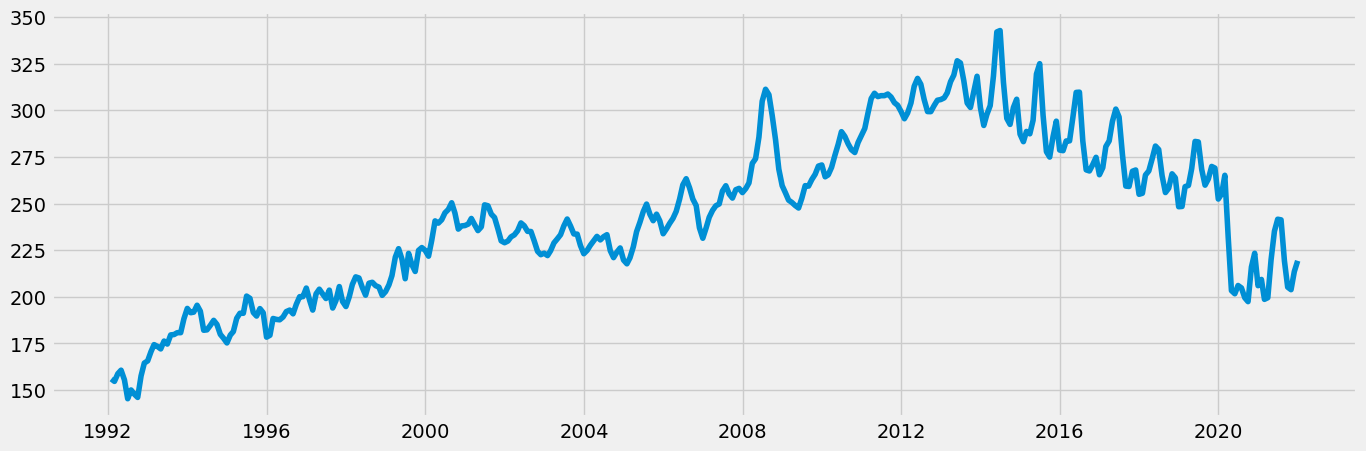

In [13]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [14]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [15]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


16

In [16]:
dups.head()

datetime
1992-01-31    False
1992-02-29    False
1992-03-31    False
1992-04-30    False
1992-05-31    False
dtype: bool

Data explored in Excel, no dups.

## 3. Time-series Analysis: Decomposition

In [17]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [18]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

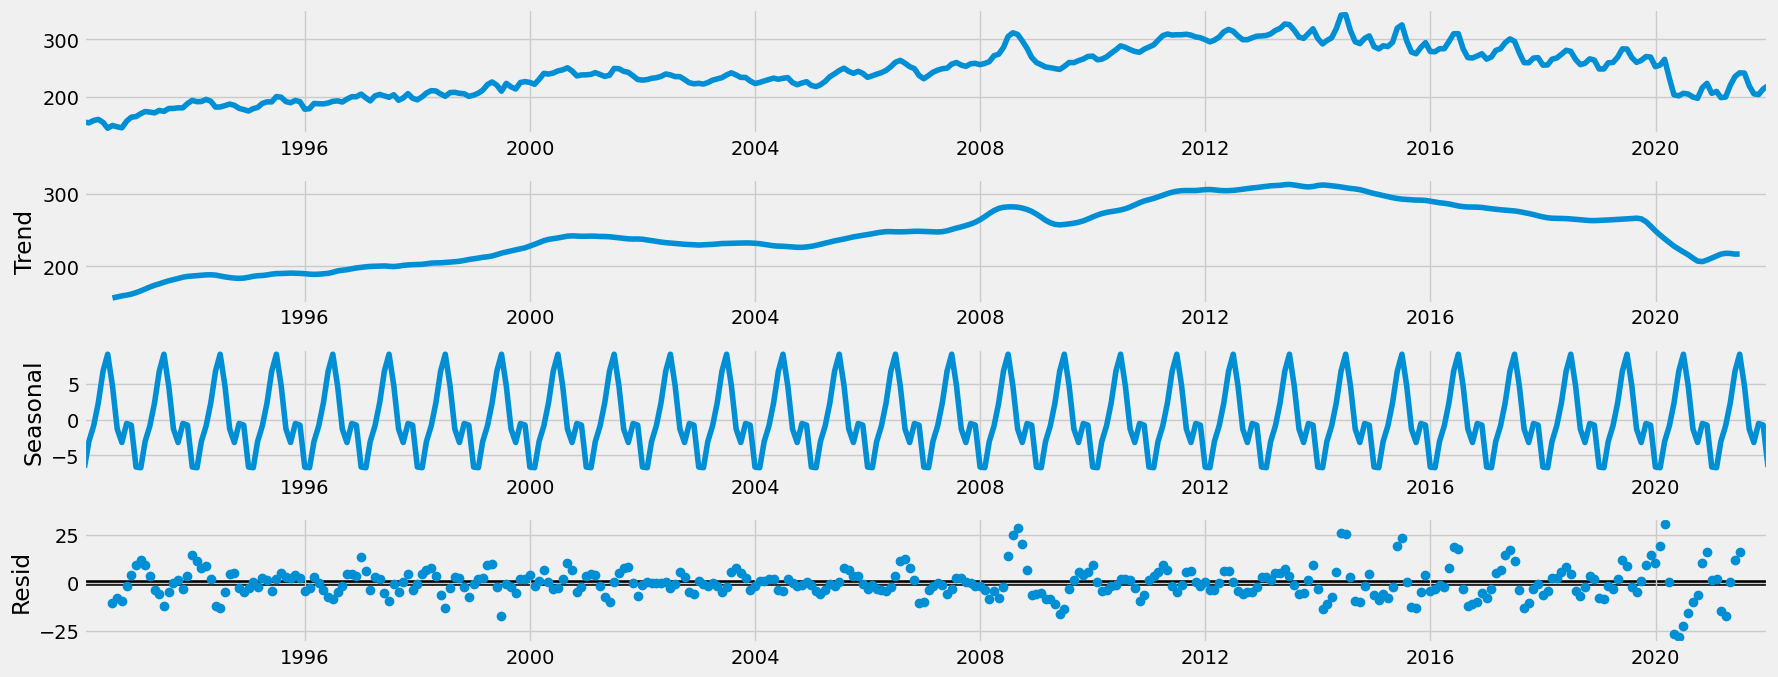

In [19]:
# Plot the separate components

decomposition.plot()
plt.show()

The data has a general upward trend that starts to take a decline around 2015. You can see the large drop in price index around 2019, this is likely accounting for Covid. There is a clear pattern of seasonality.

## 4. Testing for Stationarity

In [20]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.871609
p-value                          0.345533
Number of Lags Used             13.000000
Number of Observations Used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64


With a test statistic larger than my critical value, i cannot reject my null hypothesis of a presence of a unit root.

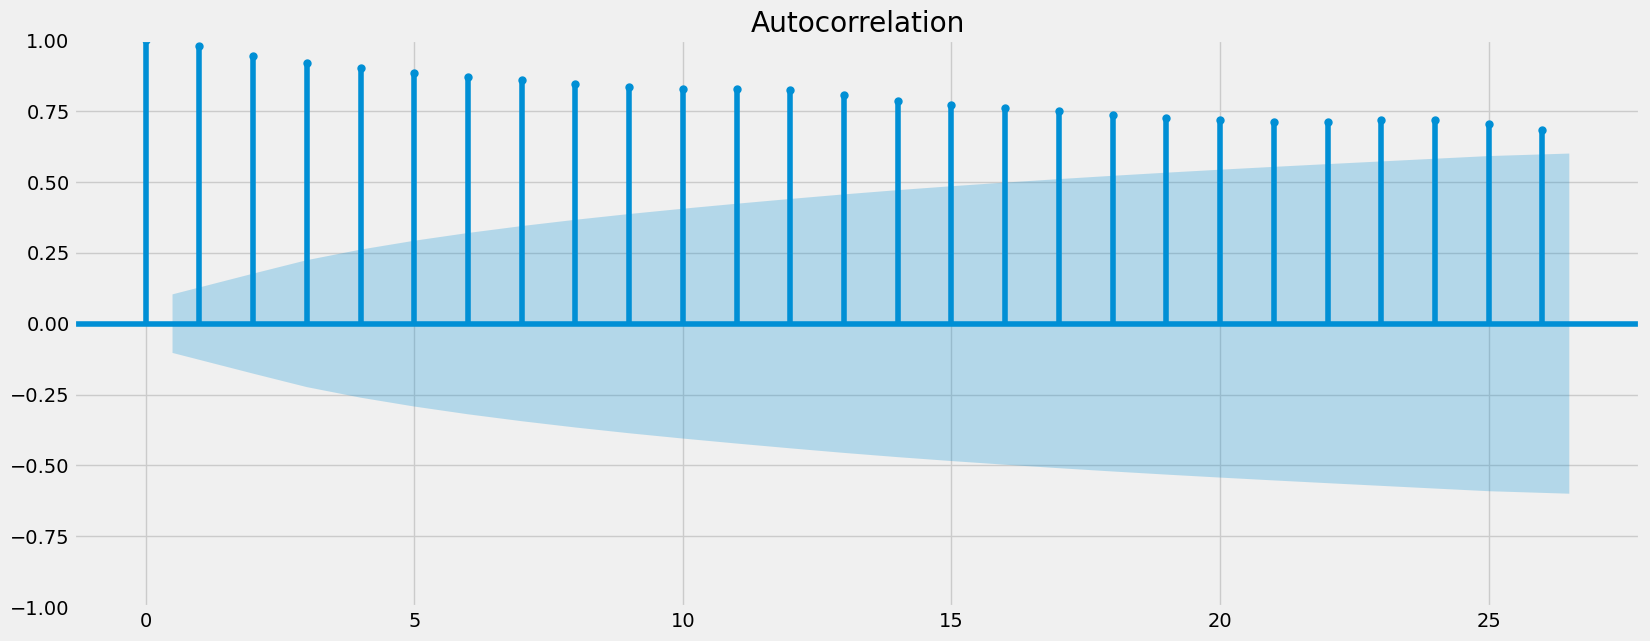

In [21]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

## 5. Stationarizing Time Series Data

In [22]:
data_diff = data_sub - data_sub.shift(1) 

In [23]:
#remove missing values as a result of differencing
data_diff.dropna(inplace = True)

In [24]:
data_diff.head()

,Value
datetime,
1992-02-29,-1.3
1992-03-31,4.1
1992-04-30,1.9
1992-05-31,-5.2
1992-06-30,-10.1


In [25]:
data_diff.columns

Index(['Value'], dtype='object')

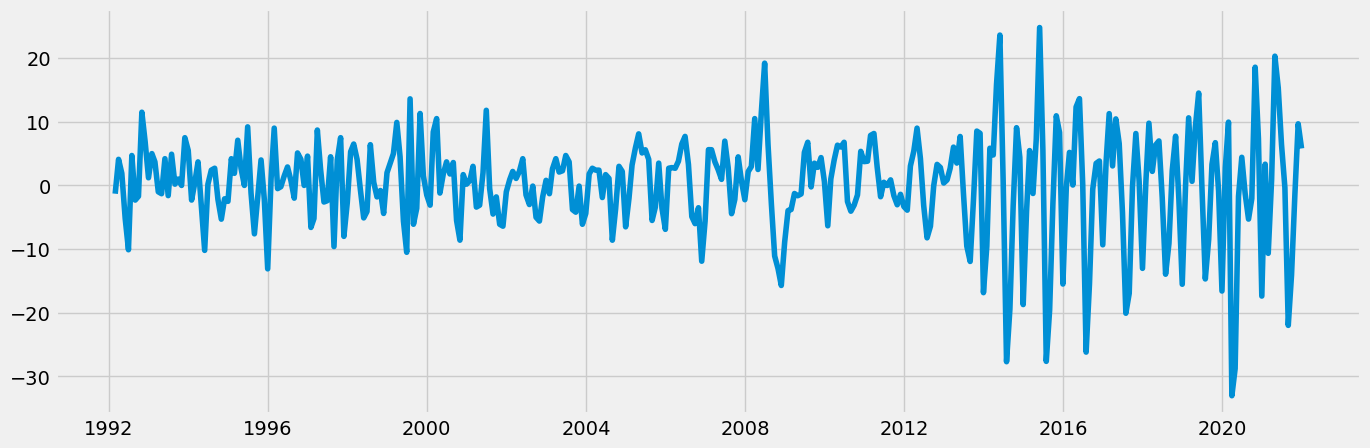

In [26]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -5.611334
p-value                          0.000001
Number of Lags Used             12.000000
Number of Observations Used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64


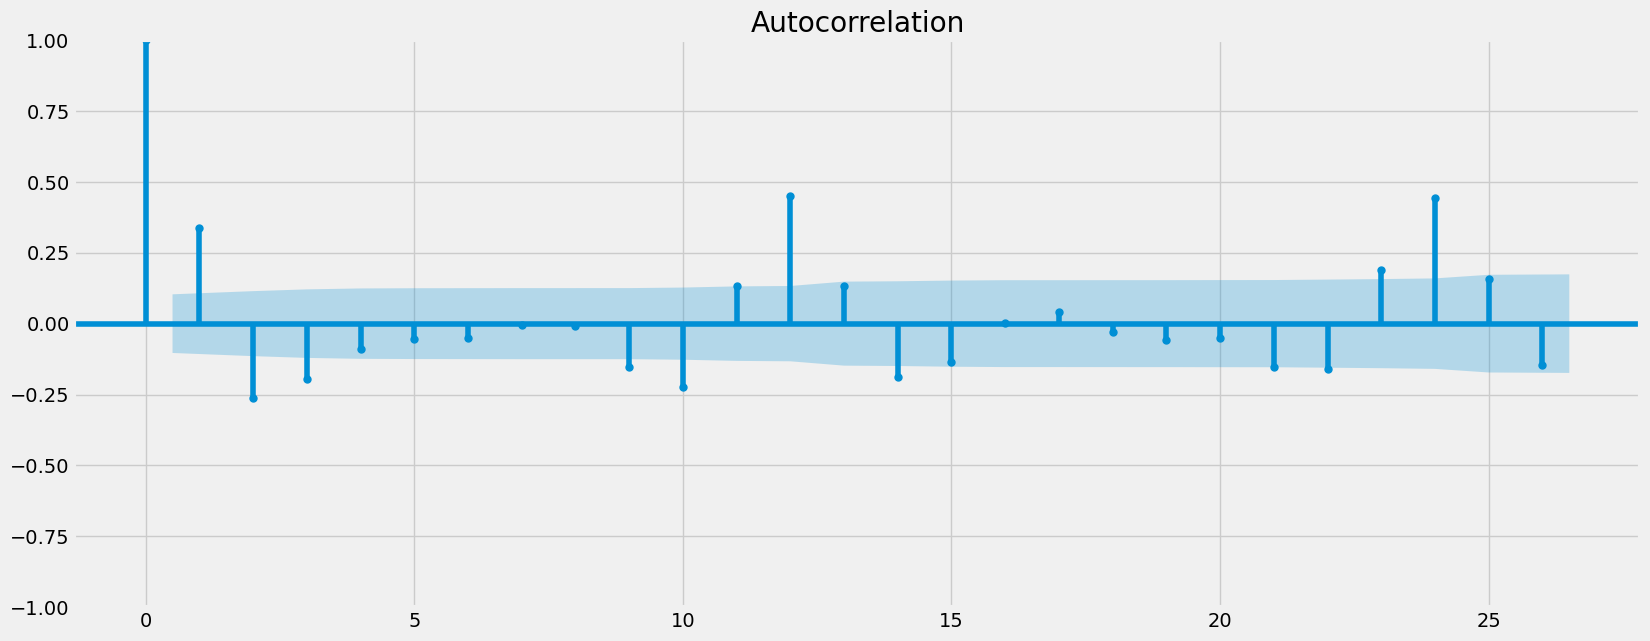

In [28]:
plot_acf(data_diff)
plt.show()